In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())

Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
# %load NN3
#!/usr/bin/env python

# In[1]:


import numpy as np
import talib
import pandas as pd
import os
import talib as ta
import time
import datetime

## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing


# In[1]:


def load_data(filename,percent):
#Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'],index_col='Date')
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * X_normal.shape[0])
    X_train = X_normal[:int(split_line), :]
    Y_train = Y[:int(split_line)]
    X_test = X_normal[int(split_line):,:]
    Y_test = Y[int(split_line):]
    Y_daybefore = Y[int(split_line)-1:-1]
  
    line=int(split_line)
    #shuffle the training set and test set
    #X_train, X_test, Y_train, Y_test = train_test_split(X_normal, Y, test_size=0.2, random_state=37)
    return X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line


# In[2]:


def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()
    
   
    optimizer='adam'
    loss='mean_squared_error'
    activation='relu'
    input_shape = (X_train.shape[1],)
    model.add(Dense(units = 64,activation=activation, input_shape = input_shape))
    model.add(Dense(units = 64, activation=activation))
    model.add(Dense(units = 32, activation=activation))
    model.add(Dense(units = 1,activation='relu'))
   
    
              
    model.compile(optimizer =optimizer, loss = loss, metrics=['mse'])

    
    return model


# In[3]:


#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    history=model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model,history


# In[5]:





# In[4]:


# test the model
def test_model(model_name, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model_name.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore


# In[5]:


#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    return  return_change_predict, return_change_real, fig_2


# In[8]:


def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0



# In[6]:


def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

def classify_range(variable_name):
    
    classification[variable_name+'_range']=0

    for i in range(classification.shape[0]):
        if classification[variable_name][i]<=0.002 and classification[variable_name][i]>=-0.002:
            classification[variable_name+'_range'][i]=0
        
        elif classification[variable_name][i]<=-0.002 and classification[variable_name][i]>=-0.004:
            classification[variable_name+'_range'][i]=-1
        
        elif classification[variable_name][i]<=-0.004 and classification[variable_name][i]>=-0.006:
            classification[variable_name+'_range'][i]=-2
        
        elif classification[variable_name][i]<=-0.006 and classification[variable_name][i]>=-0.008:
            classification[variable_name+'_range'][i]=-3
        
        elif classification[variable_name][i]<=-0.008 and classification[variable_name][i]>=-0.010:
            classification[variable_name+'_range'][i]=-4
        
        elif classification[variable_name][i]<=-0.010 and classification[variable_name][i]>=-0.012:
            classification[variable_name+'_range'][i]=-5
        
        elif classification[variable_name][i]<=-0.012 and classification[variable_name][i]>=-0.014:
            classification[variable_name+'_range'][i]=-6
        
        elif classification[variable_name][i]<=-0.014 and classification[variable_name][i]>=-0.016:
            classification[variable_name+'_range'][i]=-7
        
        elif classification[variable_name][i]<=-0.016 and classification[variable_name][i]>=-0.018:
            classification[variable_name+'_range'][i]=-8
        
        elif classification[variable_name][i]<=-0.018 and classification[variable_name][i]>=-0.020:
            classification[variable_name+'_range'][i]=-9
        
        elif classification[variable_name][i]<=-0.020:
            classification[variable_name+'_range'][i]=-10
        
        #positive value
        elif classification[variable_name][i]<=0.004 and classification[variable_name][i]>=0.002:
            classification[variable_name+'_range'][i]=1
        
        elif classification[variable_name][i]<=0.006 and classification[variable_name][i]>=0.004:
            classification[variable_name+'_range'][i]=2
        
        elif classification[variable_name][i]<=0.008 and classification[variable_name][i]>=0.006:
            classification[variable_name+'_range'][i]=3
        
        elif classification[variable_name][i]<=0.010 and classification[variable_name][i]>=0.008:
            classification[variable_name+'_range'][i]=4
        
        elif classification[variable_name][i]<=0.012 and classification[variable_name][i]>=0.010:
            classification[variable_name+'_range'][i]=5
        
        elif classification[variable_name][i]<=0.014 and classification[variable_name][i]>=0.012:
            classification[variable_name+'_range'][i]=6
        
        elif classification[variable_name][i]<=0.016 and classification[variable_name][i]>=0.014:
            classification[variable_name+'_range'][i]=7
        
        elif classification[variable_name][i]<=0.018 and classification[variable_name][i]>=0.016:
            classification[variable_name+'_range'][i]=8
        
        elif classification[variable_name][i]<=0.020 and classification[variable_name][i]>=0.018:
            classification[variable_name+'_range'][i]=9
         
        else:
            classification[variable_name+'_range'][i]=10
    return classification

def find_the_successful_rate(classification):
    successful_number=0
    for i in range(classification.shape[0]):
        if classification['real_y_test_range'][i]==classification['real_y_predict_range'][i]:
            successful_number+=1
    successful_rate=round(successful_number/classification.shape[0],4)
    return successful_rate



(426, 98)
(426,)
(180, 98)
(180,)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 340 samples, validate on 86 samples
Epoch 1/100
340/340 [==============================] - 1s 2ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2/100
340/340 [==============================] - 0s 53us/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 3/100
340/340 [==============================] - 0s 67us/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 4/100
340/340 [==============================] - 0s 53us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 5/100
340/340 [==============================] - 0s 53us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 6/100
340/340 [==============================] - 0s 50us/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0059 - val

340/340 [==============================] - 0s 56us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 51/100
340/340 [==============================] - 0s 53us/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 52/100
340/340 [==============================] - 0s 47us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 53/100
340/340 [==============================] - 0s 53us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 54/100
340/340 [==============================] - 0s 50us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 55/100
340/340 [==============================] - 0s 53us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 56/100
340/340 [=

Epoch 100/100
340/340 [==============================] - 0s 50us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0120 - val_mean_squared_error: 0.0120


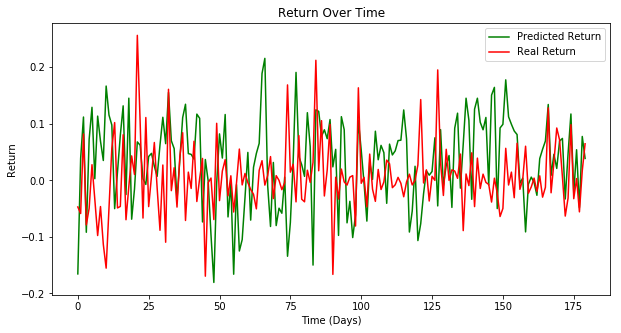

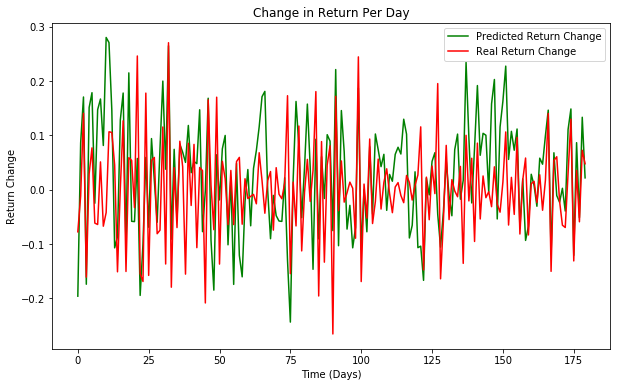

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.047059       -0.165443                -10   
2018-11-26    -0.058642        0.039056                -10   
2018-11-27     0.081967        0.111984                 10   
2018-11-28    -0.078788       -0.091825                -10   
2018-11-29    -0.049342        0.072561                -10   
2018-11-30     0.027682        0.129189                 10   
2018-12-01    -0.033670        0.002899                -10   
2018-12-02    -0.097561        0.113615                -10   
2018-12-03    -0.046332        0.069347                -10   
2018-12-04    -0.113360        0.035111                -10   
2018-12-05    -0.155251        0.166755                -10   
2018-12-06    -0.048649        0.115419                -10   
2018-12-07     0.056818        0.097916                 10   
2018-12-08     0.102151       -0.050050                 10   
2018-12-

C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


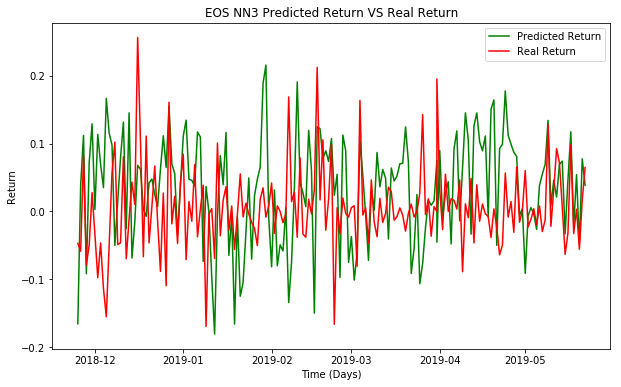

In [3]:
#EOS
#load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line = load_data("merge_EOS-USD.csv",0.7035)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model_32,history_32 = fit_model(model, X_train, Y_train, 32, 100, .2)

#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model_32, X_test, Y_test)

#return change
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("EOS NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

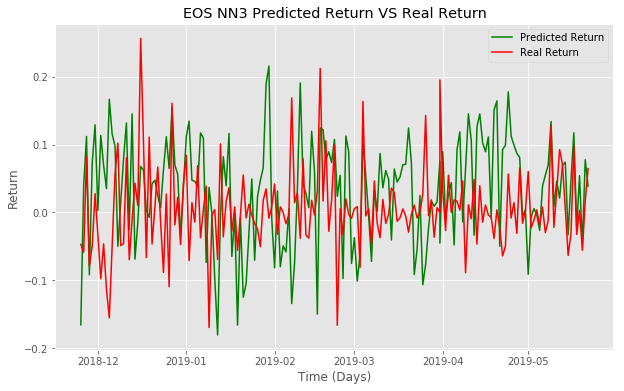

In [4]:
fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("EOS NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

(670, 112)
(670,)
(180, 112)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                7232      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 13,505
Trainable params: 13,505
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 536 samples, validate on 134 samples
Epoch 1/100
536/536 [==============================] - 1s 1ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 2/100
536/536 [==============================] - 0s 65us/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 3/100
536/536 [==============================] - 0s 52us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/100
536/536 [==============================] - 0s 48us/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 5/100
536/536 [==============================] - 0s 56us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/100
536/536 [==============================] - 0s 50us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0053 - va

536/536 [==============================] - 0s 60us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 51/100
536/536 [==============================] - 0s 56us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 52/100
536/536 [==============================] - 0s 65us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 53/100
536/536 [==============================] - 0s 48us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 54/100
536/536 [==============================] - 0s 60us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 55/100
536/536 [==============================] - 0s 60us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 56/100
536/536 [=

536/536 [==============================] - 0s 54us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 100/100
536/536 [==============================] - 0s 56us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0070 - val_mean_squared_error: 0.0070


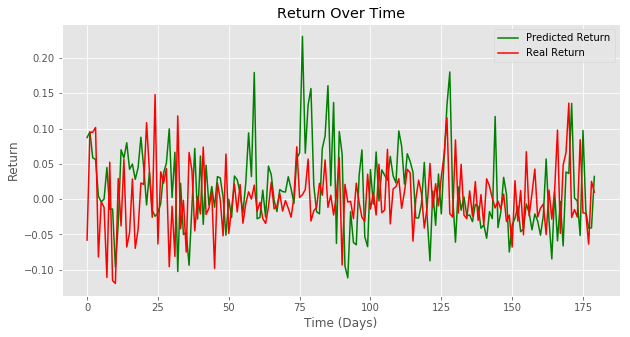

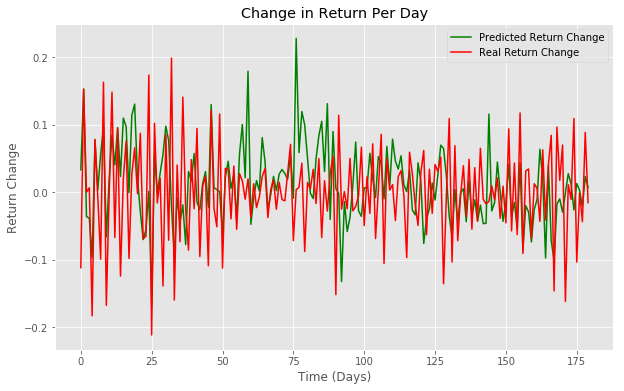

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.058028        0.087255                -10   
2018-11-26     0.094647        0.095249                 10   
2018-11-27     0.094796        0.058616                 10   
2018-11-28     0.101435        0.056107                 10   
2018-11-29    -0.081898        0.004264                -10   
2018-11-30    -0.003578       -0.004040                 -1   
2018-12-01    -0.011763        0.000153                 -5   
2018-12-02    -0.111014        0.044773                -10   
2018-12-03     0.052290       -0.014441                 10   
2018-12-04    -0.115457       -0.014048                -10   
2018-12-05    -0.119473       -0.096367                -10   
2018-12-06     0.029063       -0.034819                 10   
2018-12-07    -0.037935        0.069848                -10   
2018-12-08     0.056453        0.058177                 10   
2018-12-

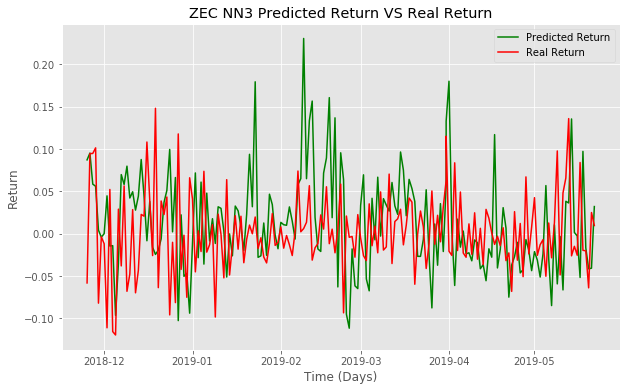

In [5]:
#ZEC
#load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line = load_data("merge_ZEC-USD.csv",0.7885)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model_32,history_32 = fit_model(model, X_train, Y_train, 32, 100, .2)

#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model_32, X_test, Y_test)

#return change
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ZEC NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

(1118, 110)
(1118,)
(180, 110)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                7104      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 894 samples, validate on 224 samples
Epoch 1/100
894/894 [==============================] - 1s 827us/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 2/100
894/894 [==============================] - 0s 55us/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/100
894/894 [==============================] - 0s 64us/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 4/100
894/894 [==============================] - 0s 52us/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/100
894/894 [==============================] - 0s 54us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 6/100
894/894 [==============================] - 0s 48us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0065 - 

894/894 [==============================] - 0s 45us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 51/100
894/894 [==============================] - 0s 52us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 52/100
894/894 [==============================] - 0s 51us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 53/100
894/894 [==============================] - 0s 52us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 54/100
894/894 [==============================] - 0s 48us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 55/100
894/894 [==============================] - 0s 50us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 56/100
894/894 [=

Epoch 100/100
894/894 [==============================] - 0s 52us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0207 - val_mean_squared_error: 0.0207


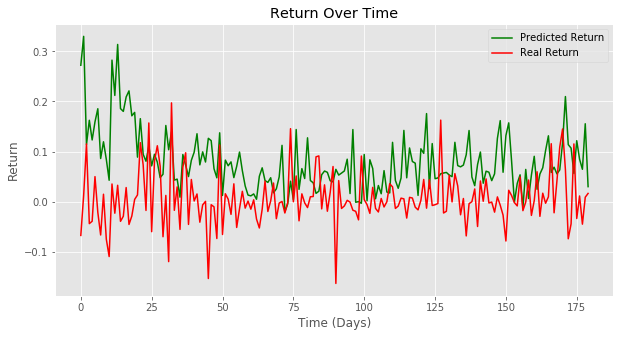

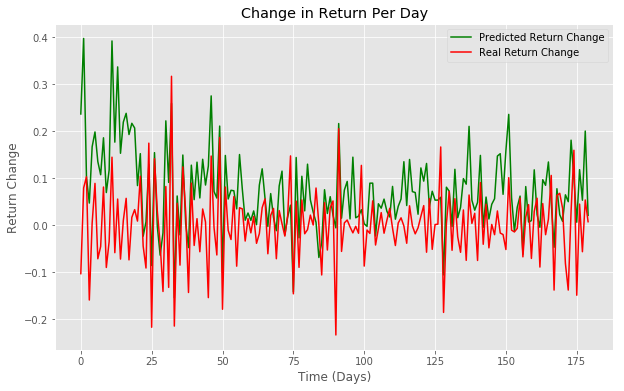

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.067495        0.272238                -10   
2018-11-26     0.012125        0.329951                  6   
2018-11-27     0.115165        0.113903                 10   
2018-11-28    -0.043945        0.162379                -10   
2018-11-29    -0.039241        0.123094                -10   
2018-11-30     0.049880        0.159294                 10   
2018-12-01    -0.021435        0.185415                -10   
2018-12-02    -0.066661        0.086062                -10   
2018-12-03     0.014691        0.119441                  7   
2018-12-04    -0.075123        0.084297                -10   
2018-12-05    -0.109678        0.042621                -10   
2018-12-06     0.035165        0.282485                 10   
2018-12-07    -0.023181        0.211994                -10   
2018-12-08     0.032590        0.313769                 10   
2018-12-

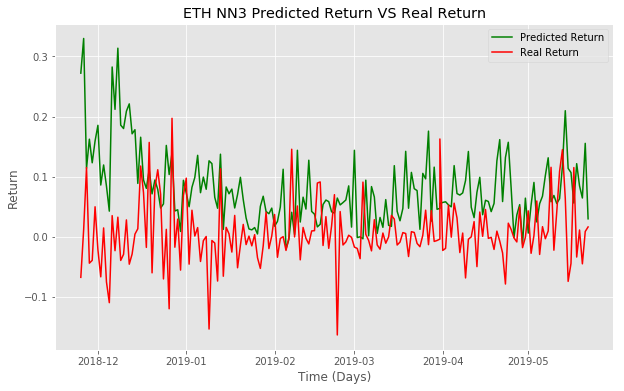

In [6]:
#ETH
#load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line = load_data("merge_ETH-USD.csv",0.8614)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model_32,history_32 = fit_model(model, X_train, Y_train, 32, 100, .2)

#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model_32, X_test, Y_test)

#return change
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ETH NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

(1316, 110)
(1316,)
(180, 110)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                7104      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1052 samples, validate on 264 samples
Epoch 1/100
1052/1052 [==============================] - 1s 903us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/100
1052/1052 [==============================] - 0s 51us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/100
1052/1052 [==============================] - 0s 51us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/100
1052/1052 [==============================] - 0s 66us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/100
1052/1052 [==============================] - 0s 74us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/100
1052/1052 [==============================] - 0s 57us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_lo

Epoch 50/100
1052/1052 [==============================] - 0s 67us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 51/100
1052/1052 [==============================] - 0s 64us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 52/100
1052/1052 [==============================] - 0s 67us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 53/100
1052/1052 [==============================] - 0s 55us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 54/100
1052/1052 [==============================] - 0s 51us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 55/100
1052/1052 [==============================] - 0s 49us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0022 - val_mean_squared_error: 0.002

Epoch 98/100
1052/1052 [==============================] - 0s 59us/step - loss: 5.5585e-04 - mean_squared_error: 5.5585e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 99/100
1052/1052 [==============================] - 0s 50us/step - loss: 6.4597e-04 - mean_squared_error: 6.4597e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 100/100
1052/1052 [==============================] - 0s 66us/step - loss: 7.9900e-04 - mean_squared_error: 7.9900e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037


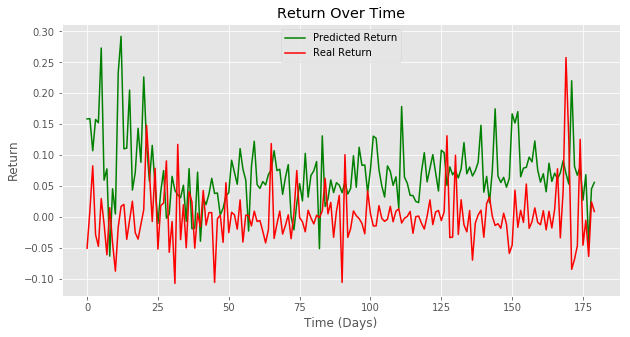

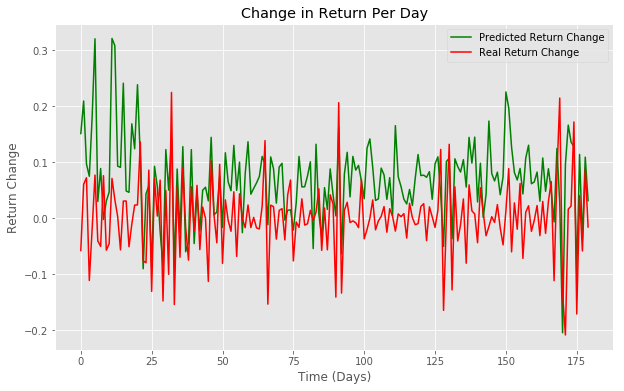

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.050767        0.158338                -10   
2018-11-26     0.010028        0.158834                  5   
2018-11-27     0.082460        0.106818                 10   
2018-11-28    -0.028790        0.157556                -10   
2018-11-29    -0.047744        0.152171                -10   
2018-11-30     0.029477        0.273132                 10   
2018-12-01    -0.011239        0.059367                 -5   
2018-12-02    -0.061434        0.077624                -10   
2018-12-03     0.014706       -0.063634                  7   
2018-12-04    -0.042342        0.045411                -10   
2018-12-05    -0.087834        0.004626                -10   
2018-12-06    -0.016591        0.233615                 -8   
2018-12-07     0.016871        0.291977                  8   
2018-12-08     0.020169        0.110072                 10   
2018-12-

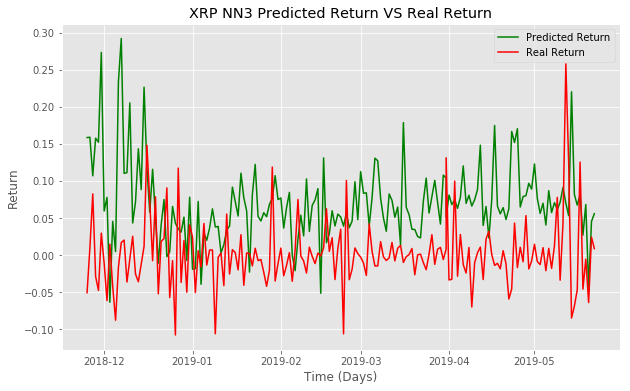

In [7]:
#XRP
#load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line = load_data("merge_XRP-USD.csv",0.8798)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model_32,history_32 = fit_model(model, X_train, Y_train, 32, 100, .2)

#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model_32, X_test, Y_test)

#return change
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("XRP NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

(1770, 108)
(1770,)
(180, 108)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                6976      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 13,249
Trainable params: 13,249
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1416 samples, validate on 354 samples
Epoch 1/100
1416/1416 [==============================] - 0s 326us/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/100
1416/1416 [==============================] - 0s 38us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 3/100
1416/1416 [==============================] - 0s 37us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/100
1416/1416 [==============================] - 0s 37us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/100
1416/1416 [==============================] - 0s 38us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 6/100
1416/1416 [==============================] - 0s 37us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_lo

1416/1416 [==============================] - 0s 31us/step - loss: 6.9763e-04 - mean_squared_error: 6.9763e-04 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 49/100
1416/1416 [==============================] - 0s 32us/step - loss: 7.0375e-04 - mean_squared_error: 7.0375e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 50/100
1416/1416 [==============================] - 0s 32us/step - loss: 6.5308e-04 - mean_squared_error: 6.5308e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 51/100
1416/1416 [==============================] - 0s 33us/step - loss: 7.1974e-04 - mean_squared_error: 7.1974e-04 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 52/100
1416/1416 [==============================] - 0s 34us/step - loss: 6.7356e-04 - mean_squared_error: 6.7356e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 53/100
1416/1416 [==============================] - 0s 39us/step - loss: 7.3798e-04 - mean_squared_error: 7.3798e-04 - val_loss: 0.0

Epoch 95/100
1416/1416 [==============================] - 0s 40us/step - loss: 5.1413e-04 - mean_squared_error: 5.1413e-04 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 96/100
1416/1416 [==============================] - 0s 40us/step - loss: 5.1147e-04 - mean_squared_error: 5.1147e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 97/100
1416/1416 [==============================] - 0s 40us/step - loss: 5.9623e-04 - mean_squared_error: 5.9623e-04 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 98/100
1416/1416 [==============================] - 0s 37us/step - loss: 5.4673e-04 - mean_squared_error: 5.4673e-04 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 99/100
1416/1416 [==============================] - 0s 38us/step - loss: 5.2065e-04 - mean_squared_error: 5.2065e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 100/100
1416/1416 [==============================] - 0s 37us/step - loss: 4.8100e-04 - mean_squared_error: 4.8100e-04 -

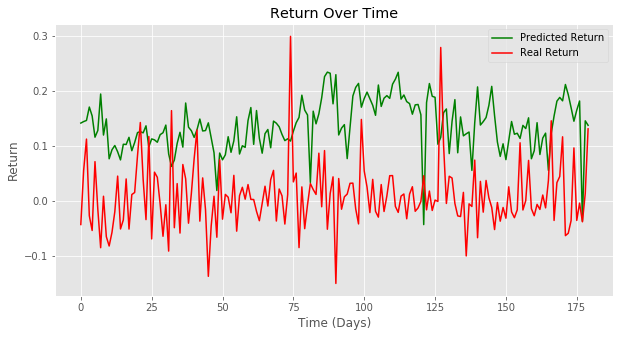

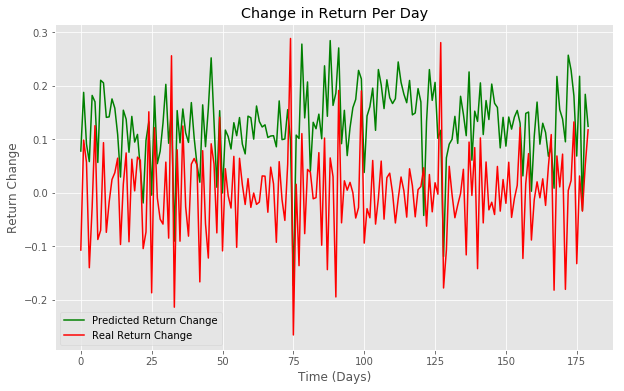

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.043450        0.141655                -10   
2018-11-26     0.055254        0.144401                 10   
2018-11-27     0.112432        0.146416                 10   
2018-11-28    -0.027433        0.170887                -10   
2018-11-29    -0.054335        0.154716                -10   
2018-11-30     0.071272        0.115913                 10   
2018-12-01    -0.015826        0.128138                 -7   
2018-12-02    -0.085765        0.194650                -10   
2018-12-03     0.008143        0.119832                  4   
2018-12-04    -0.065590        0.149255                -10   
2018-12-05    -0.082642        0.076498                -10   
2018-12-06    -0.057671        0.092968                -10   
2018-12-07    -0.020000        0.100732                 -9   
2018-12-08     0.044898        0.089219                 10   
2018-12-

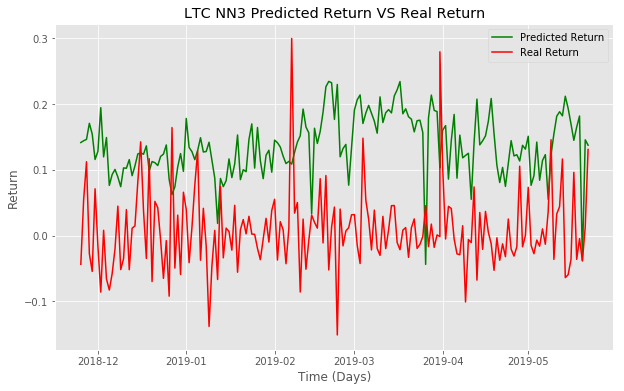

In [10]:
#LTC
#load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line = load_data("merge_LTC-USD.csv",0.9077)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model_32,history_32 = fit_model(model, X_train, Y_train, 32, 100, .2)

#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model_32, X_test, Y_test)

#return change
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("LTC NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

(2965, 105)
(2965,)
(180, 105)
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 64)                6784      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2075 samples, validate on 890 samples
Epoch 1/100
2075/2075 [==============================] - 1s 250us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/100
2075/2075 [==============================] - 0s 39us/step - loss: 7.4722e-04 - mean_squared_error: 7.4722e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/100
2075/2075 [==============================] - 0s 42us/step - loss: 6.5686e-04 - mean_squared_error: 6.5686e-04 - val_loss: 4.1437e-04 - val_mean_squared_error: 4.1437e-04
Epoch 4/100
2075/2075 [==============================] - 0s 40us/step - loss: 5.5654e-04 - mean_squared_error: 5.5654e-04 - val_loss: 4.1788e-04 - val_mean_squared_error: 4.1788e-04
Epoch 5/100
2075/2075 [==============================] - 0s 39us/step - loss: 5.2742e-04 - mean_squared_error: 5.2742e-04 - val_loss: 4.5066e-04 - val_mean_squared_error: 4.5066e-04
Epoch 6/100
2075/2075 [==============================] - 0s 39us/s

2075/2075 [==============================] - 0s 38us/step - loss: 5.1197e-04 - mean_squared_error: 5.1197e-04 - val_loss: 8.9336e-04 - val_mean_squared_error: 8.9336e-04
Epoch 48/100
2075/2075 [==============================] - ETA: 0s - loss: 4.7335e-04 - mean_squared_error: 4.7335e- - 0s 34us/step - loss: 4.3233e-04 - mean_squared_error: 4.3233e-04 - val_loss: 6.4473e-04 - val_mean_squared_error: 6.4473e-04
Epoch 49/100
2075/2075 [==============================] - 0s 35us/step - loss: 3.9926e-04 - mean_squared_error: 3.9926e-04 - val_loss: 2.8217e-04 - val_mean_squared_error: 2.8217e-04
Epoch 50/100
2075/2075 [==============================] - 0s 33us/step - loss: 3.1562e-04 - mean_squared_error: 3.1562e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 51/100
2075/2075 [==============================] - 0s 33us/step - loss: 1.5465e-04 - mean_squared_error: 1.5465e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 52/100
2075/2075 [==============================

Epoch 92/100
2075/2075 [==============================] - 0s 35us/step - loss: 5.6562e-05 - mean_squared_error: 5.6562e-05 - val_loss: 2.4554e-04 - val_mean_squared_error: 2.4554e-04
Epoch 93/100
2075/2075 [==============================] - 0s 34us/step - loss: 1.1905e-04 - mean_squared_error: 1.1905e-04 - val_loss: 5.1457e-04 - val_mean_squared_error: 5.1457e-04
Epoch 94/100
2075/2075 [==============================] - 0s 37us/step - loss: 5.9295e-05 - mean_squared_error: 5.9295e-05 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 95/100
2075/2075 [==============================] - 0s 45us/step - loss: 6.9245e-05 - mean_squared_error: 6.9245e-05 - val_loss: 4.8635e-04 - val_mean_squared_error: 4.8635e-04
Epoch 96/100
2075/2075 [==============================] - 0s 33us/step - loss: 7.8715e-05 - mean_squared_error: 7.8715e-05 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 97/100
2075/2075 [==============================] - 0s 33us/step - loss: 4.3195e-05 - mean_squa

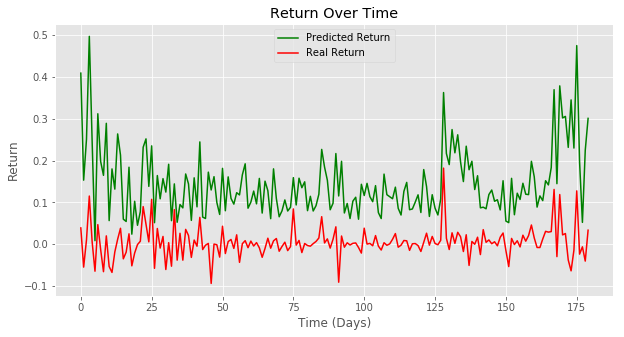

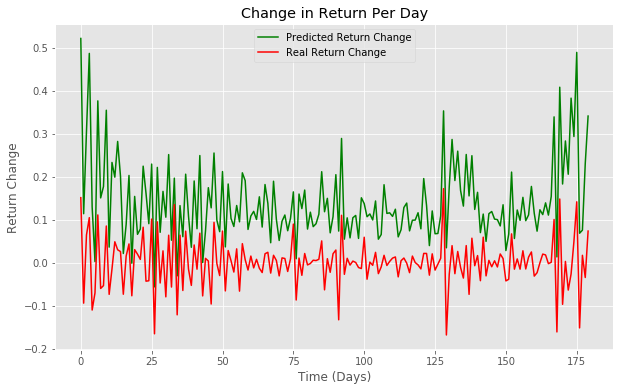

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25     0.038930        0.409272                 10   
2018-11-26    -0.054833        0.153207                -10   
2018-11-27     0.010146        0.250768                  5   
2018-11-28     0.115240        0.497306                 10   
2018-11-29     0.005427        0.245309                  2   
2018-11-30    -0.064623        0.008404                -10   
2018-12-01     0.046834        0.312106                 10   
2018-12-02    -0.012770        0.197893                 -6   
2018-12-03    -0.065748        0.164756                -10   
2018-12-04     0.019897        0.289247                  9   
2018-12-05    -0.053416        0.056438                -10   
2018-12-06    -0.067518        0.180117                -10   
2018-12-07    -0.018538        0.131772                 -9   
2018-12-08     0.011840        0.263826                  5   
2018-12-

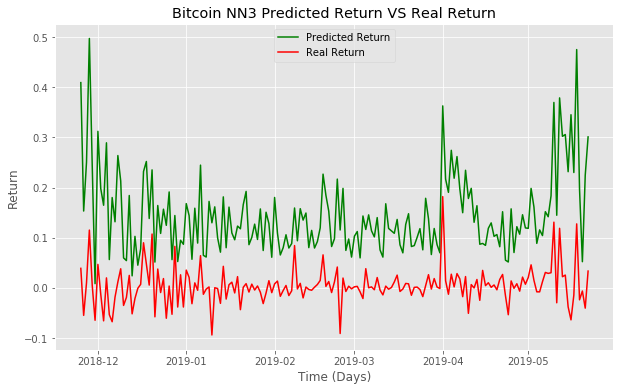

In [11]:
#Bitcoin
#load the data
X_train, Y_train, X_test, Y_test, dataset_total,Y_daybefore,line = load_data("Bitcoin.csv",0.9428)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model_32,history_32 = fit_model(model, X_train, Y_train, 32, 100, .3)

#test the model
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model_32, X_test, Y_test)

#return change
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)
print(successful_rate)

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("Bitcoin NN3 Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()